<a href="https://colab.research.google.com/github/mvakhmenin/MindSet/blob/main/%D0%A2%D0%B8%D0%BF%D1%8B%20%D1%81%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85%20%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Типы стационарности временных рядов</h1>
Теория от сюда: http://distrland.blogspot.com/2020/06/python_28.html<br>
Общая информация о стационарности здесь: https://colab.research.google.com/drive/1OZ7L3Z-L04U4TvQs7psTALzg2ugsOgtk<br>

<h2>Типы стационарности</h2>

* **Строго стационарный**: строгий стационарный ряд удовлетворяет математическому 
определению стационарного процесса. Для строгого стационарного ряда среднее значение, дисперсия и ковариация не являются функцией времени. Цель состоит в том, чтобы преобразовать нестационарный ряд в строгий стационарный ряд для прогнозирования.
* **Стационарный тренд**: ряд, который не имеет единичного корня, но демонстрирует тренд, называется стационарным рядом тренда. После удаления трендовой составляющей, результирующий ряд будет строго стационарным. Тест KPSS классифицирует ряд как стационарный при отсутствии единичного корня. Это означает, что ряд может быть строго стационарным или стационарным по тренду.
* **Разностно-стационарный**: временной ряд, который можно сделать строгим стационарным с помощью разностей, попадает в категорию разностно-стационарных. Тест ADF также известен как тест разностной стационарности.

<h2>Тесты на стационарность</h2>

* **Расширенный тест Дики — Фуллера ADF (Augmented Dickey Fuller)** - один из самых популярных статистических тестов.<br>
Нулевая гипотеза: ряд имеет единичный корень (значение a = 1)<br>
Альтернативная гипотеза: ряд не имеет единичного корня.<br>
Если нам не удастся отвергнуть нулевую гипотезу, мы можем сказать, что ряд нестационарный (значение статистики теста меньше критического значения, p-value стремится к 0). Это означает, что ряд может быть линейным или разностно-стационарным.

* **Тест KPSS (Kwiatkowski-Phillips-Schmidt-Shin, Квятковский-Филлипс-Шмидт-Шин)**.
Нулевая гипотеза: стационарный процесс тренда.<br>
Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).<br>

In [ ]:
pip install sktime

In [ ]:
pip install yadisk # документация - https://yadisk.readthedocs.io/

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import yadisk

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
try:
  df_init = pd.read_csv('prices2017-2021.csv', 
                        sep=';', 
                        usecols=[0, 1, 2, 3, 4, 5], 
                        skiprows=1,
                        header=0,
                        names=['Dates', 'Sand', 'Stone', 'Concreat', 'Electricity', 'Cement'])
except:
  print('Файл не найден, скачиваю файл')
  ya = yadisk.YaDisk(token="xxxxx")

  # Check if the token is valid
  if ya.check_token():
    print('Токен работает')
  else: 
    print('Какая-то проблема с токеном, получаем новый токен')
    # Ниже указываются ID и Пароль, которые можно получить по ссылке https://oauth.yandex.ru/ 
    # для приложения: GoogleColab-YandexDisk
    ya = yadisk.YaDisk("805fcf6bb2ee4d35bae767e44044574e", "3c5eef2e166e4e16890b64a6ef3f337d")
    url = ya.get_code_url()

    print("Go to the following url: %s" % url)
    code = input("Enter the confirmation code: ")

    try:
      response = ya.get_token(code)
    except yadisk.exceptions.BadRequestError:
      print("Bad code")
      sys.exit(1)

    ya.token = response.access_token

    if ya.check_token():
      print("Sucessfully received token!")
    else:
      print("Something went wrong. Not sure how though...")

      # Скачиваем данные с Яндекс.диска
    files = ['prices2017-2021.csv']
    for f in files:
      print('Скачиваю файл', f)
      ya.download("/"+f, f)

    df_init = pd.read_csv('prices2017-2021.csv', 
                    sep=';', 
                    usecols=[0, 1, 2, 3, 4, 5], 
                    skiprows=1,
                    header=0,
                    names=['Dates', 'Sand', 'Stone', 'Concreat', 'Electricity', 'Cement'])


In [ ]:
# Комментарии по загрузке и очистке данных в предыдущей работе
# https://colab.research.google.com/drive/1Rib2MpOHIH51M2tZ0K2Q5kGRghouexcj
# Очищаем данные и исправляем типы 
df_init.Sand = df_init.Sand.apply(lambda x: str(x).replace(',', '.'))
df_init.Stone = df_init.Stone.apply(lambda x: str(x).replace(',', '.'))
df_init.Concreat = df_init.Concreat.apply(lambda x: str(x).replace(',', '.'))
df_init.Electricity = df_init.Electricity.apply(lambda x: str(x).replace(',', '.'))
df_init.Cement = df_init.Cement.apply(lambda x: str(x).replace(',', '.'))

df_init.Stone = df_init.Stone.apply(lambda x: str(x).replace(' ', ''))
df_init.Concreat = df_init.Concreat.apply(lambda x: str(x).replace(' ', ''))
df_init.Electricity = df_init.Electricity.apply(lambda x: str(x).replace(' ', ''))
df_init.Cement = df_init.Cement.apply(lambda x: str(x).replace(' ', ''))

df_init.Sand = pd.to_numeric(df_init.Sand)
df_init.Stone = pd.to_numeric(df_init.Stone)
df_init.Concreat = pd.to_numeric(df_init.Concreat)
df_init.Electricity = pd.to_numeric(df_init.Electricity)
df_init.Cement = pd.to_numeric(df_init.Cement)

df_init.Dates = pd.to_datetime(df_init.Dates)
df_init.set_index('Dates', inplace=True)

# Меняем тип индекса датафрейма на Period в соответствии с требованиями Sktime
df_init.index = pd.period_range(start=df_init.index[0], end=df_init.index[-1], freq='M')

In [ ]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y)

In [ ]:
def plot_ts(df_init, df_mod=[], title='', labels=['', '']):
  df_init.plot(figsize=(15,6), grid=True, title=title, label=labels[0])
  if len(df_mod)>0:
    df_mod.plot(figsize=(15,6), grid=True, title=title, label=labels[1])
    plt.legend()
  print('Исходный ряд')
  print(f'Критерий Дикки-Фуллера: {sm.tsa.stattools.adfuller(df_init.fillna(0))[0]:.10f}')
  print(f'p-value: {sm.tsa.stattools.adfuller(df_init.fillna(0))[1]:.10f}')
  print(f'Критические значения {sm.tsa.stattools.adfuller(df_init.fillna(0))[4]}')
  if sm.tsa.stattools.adfuller(df_init.fillna(0))[0] > sm.tsa.stattools.adfuller(df_init.fillna(0))[4]['1%']:
    adf_init = False
    print(f'Ряд не стационарный по ADF, так как значение критерия Дикки-Фуллера ({sm.tsa.stattools.adfuller(df_init.fillna(0))[0]:.10f}) больше критического значения 1% ({sm.tsa.stattools.adfuller(df_init.fillna(0))[4]["1%"]:.10f})')
  else:
    adf_init = True
    print(f'Ряд стационарный по ADF, так как значение критерия Дикки-Фуллера ({sm.tsa.stattools.adfuller(df_init.fillna(0))[0]:.10f}) меньше критического значения 1% ({sm.tsa.stattools.adfuller(df_init.fillna(0))[4]["1%"]:.10f})')
  print()
  print(f'Критерий KPSS: {sm.tsa.stattools.kpss(df_init.fillna(0))[0]:.10f}')
  print(f'p-value: {sm.tsa.stattools.kpss(df_init.fillna(0))[1]:.10f}')
  print(f'Критические значения {sm.tsa.stattools.kpss(df_init.fillna(0))[3]}')
  if sm.tsa.stattools.kpss(df_init.fillna(0))[0] > sm.tsa.stattools.kpss(df_init.fillna(0))[3]['1%']:
    kpss_init = False
    print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({sm.tsa.stattools.kpss(df_init.fillna(0))[0]:.10f}) больше критического значения 1% ({sm.tsa.stattools.kpss(df_init.fillna(0))[3]["1%"]:.10f})')
  else:
    kpss_init = True
    print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({sm.tsa.stattools.kpss(df_init.fillna(0))[0]:.10f}) меньше критического значения 1% ({sm.tsa.stattools.kpss(df_init.fillna(0))[3]["1%"]:.10f})')
  print()
  
  if len(df_mod)>0:
    print()
    print('Модифицированный ряд ряд')
    print(f'Критерий Дикки-Фуллера: {sm.tsa.stattools.adfuller(df_mod.fillna(0))[0]:.10f}')
    print(f'p-value: {sm.tsa.stattools.adfuller(df_mod.fillna(0))[1]:.10f}')
    print(f'Критические значения {sm.tsa.stattools.adfuller(df_mod.fillna(0))[4]}')
    if sm.tsa.stattools.adfuller(df_mod.fillna(0))[0] > sm.tsa.stattools.adfuller(df_mod.fillna(0))[4]['1%']:
      adf_mod = False
      print(f'Ряд не стационарный по ADF, так как значение критерия Дикки-Фуллера ({sm.tsa.stattools.adfuller(df_mod.fillna(0))[0]:.10f}) больше критического значения 1% ({sm.tsa.stattools.adfuller(df_mod.fillna(0))[4]["1%"]:.10f})')
    else:
      adf_mod = True
      print(f'Ряд стационарный по ADF, так как значение критерия Дикки-Фуллера ({sm.tsa.stattools.adfuller(df_mod.fillna(0))[0]:.10f}) меньше критического значения 1% ({sm.tsa.stattools.adfuller(df_mod.fillna(0))[4]["1%"]:.10f})')
      
    print()
    print(f'Критерий KPSS: {sm.tsa.stattools.kpss(df_mod.fillna(0))[0]:.10f}')
    print(f'p-value: {sm.tsa.stattools.kpss(df_mod.fillna(0))[1]:.10f}')
    print(f'Критические значения {sm.tsa.stattools.kpss(df_mod.fillna(0))[3]}')
    if sm.tsa.stattools.kpss(df_mod.fillna(0))[0] > sm.tsa.stattools.kpss(df_mod.fillna(0))[3]['1%']:
      kpss_mod = False
      print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({sm.tsa.stattools.kpss(df_mod.fillna(0))[0]:.10f}) больше критического значения 1% ({sm.tsa.stattools.kpss(df_mod.fillna(0))[3]["1%"]:.10f})')
    else:
      kpss_mod = True
      print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({sm.tsa.stattools.kpss(df_mod.fillna(0))[0]:.10f}) меньше критического значения 1% ({sm.tsa.stattools.kpss(df_mod.fillna(0))[3]["1%"]:.10f})')

Исходный ряд
Критерий Дикки-Фуллера: 0.8153688792
p-value: 0.9918802434
Критические значения {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Ряд не стационарный по ADF, так как значение критерия Дикки-Фуллера (0.8153688792) больше критического значения 1% (-3.4816817173)

Критерий KPSS: 1.6513122354
p-value: 0.0100000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд не стационарный по KPSS, так как значение критерия KPSS (1.6513122354) больше критического значения 1% (0.7390000000)



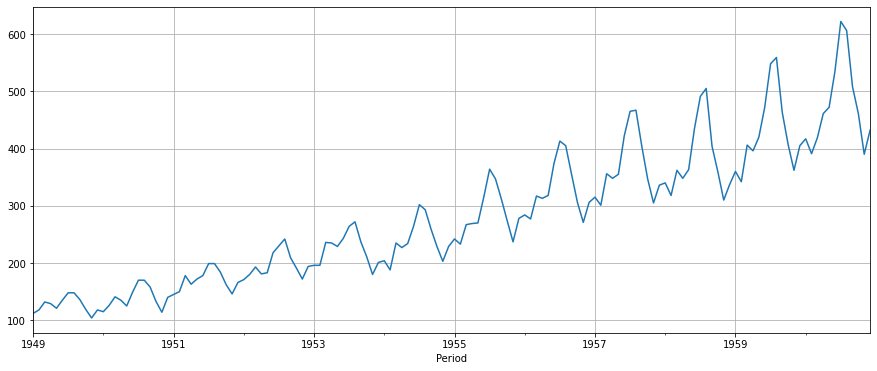

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

plot_ts(y)

Исходный ряд
Критерий Дикки-Фуллера: 0.8153688792
p-value: 0.9918802434
Критические значения {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Ряд не стационарный по ADF, так как значение критерия Дикки-Фуллера (0.8153688792) больше критического значения 1% (-3.4816817173)

Критерий KPSS: 1.6513122354
p-value: 0.0100000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд не стационарный по KPSS, так как значение критерия KPSS (1.6513122354) больше критического значения 1% (0.7390000000)


Модифицированный ряд ряд
Критерий Дикки-Фуллера: -5.8518612943
p-value: 0.0000003574
Критические значения {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}
Ряд стационарный по ADF, так как значение критерия Дикки-Фуллера (-5.8518612943) меньше критического значения 1% (-3.4797425867)

Критерий KPSS: 0.1320119253
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


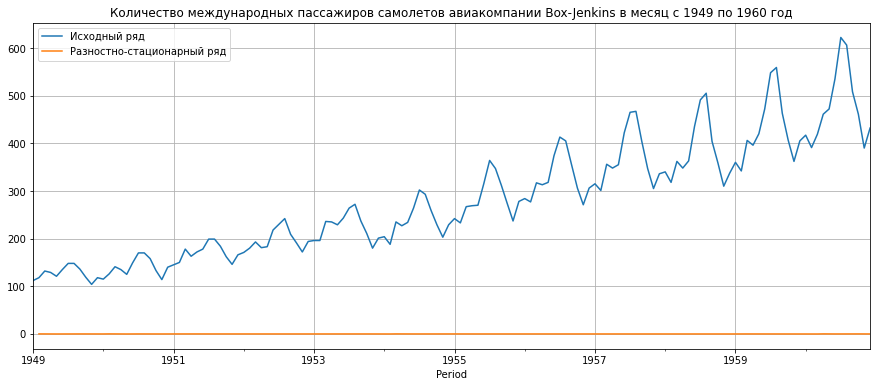

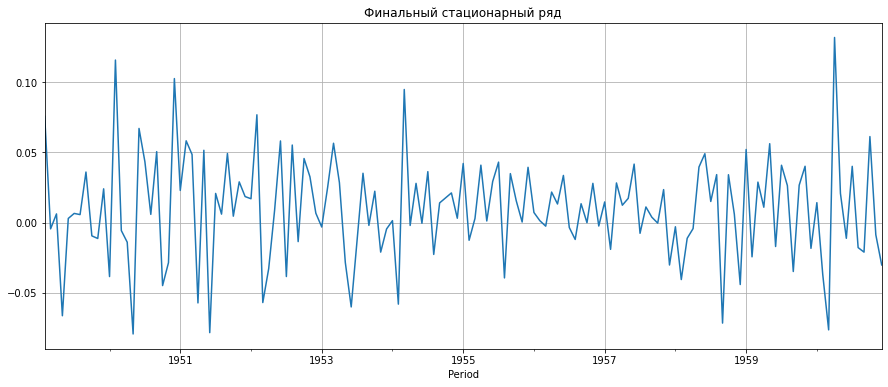

In [ ]:
transformer = TransformedTargetForecaster(steps=[
                                                  ("logtransform", LogTransformer()),
                                                  ("deseasonalizer", Deseasonalizer(sp=12, model='multiplicative')),
                                                  ("differencer", Differencer()),
                                                  ("forecaster", NaiveForecaster(strategy="drift"))
                                                  ]
                                          )
y_hat = transformer.fit_transform(y)

plot_ts(y, 
        y_hat,
        title='Количество международных пассажиров самолетов авиакомпании Box-Jenkins в месяц с 1949 по 1960 год', 
        labels=['Исходный ряд', 'Разностно-стационарный ряд'])
plt.show()

y_hat.plot(figsize=(15,6), grid=True, title='Финальный стационарный ряд')
None

Исходный ряд
Критерий Дикки-Фуллера: 0.8153688792
p-value: 0.9918802434
Критические значения {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Ряд не стационарный по ADF, так как значение критерия Дикки-Фуллера (0.8153688792) больше критического значения 1% (-3.4816817173)

Критерий KPSS: 1.6513122354
p-value: 0.0100000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд не стационарный по KPSS, так как значение критерия KPSS (1.6513122354) больше критического значения 1% (0.7390000000)


Модифицированный ряд ряд
Критерий Дикки-Фуллера: -2.8292668242
p-value: 0.0542132903
Критические значения {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Ряд не стационарный по ADF, так как значение критерия Дикки-Фуллера (-2.8292668242) больше критического значения 1% (-3.4816817173)

Критерий KPSS: 0.0238976144
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0

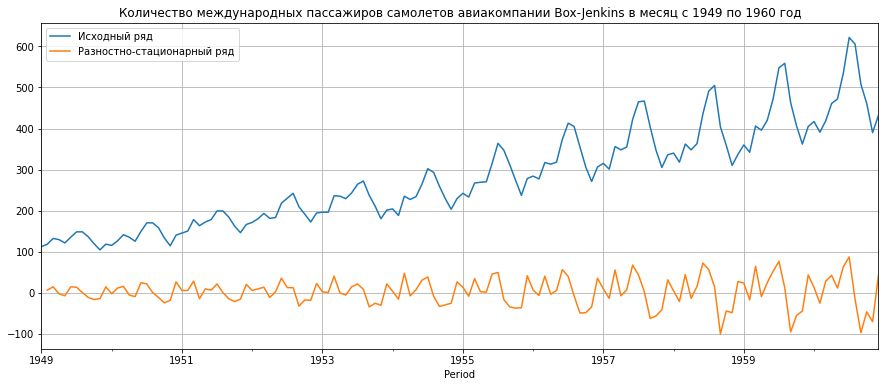

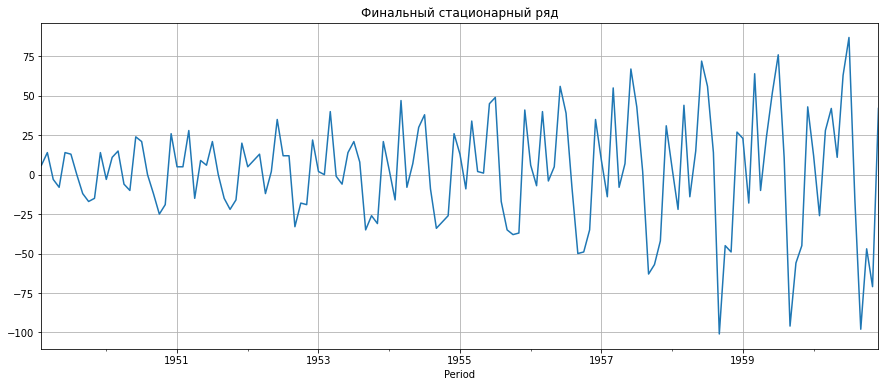

In [ ]:
transformer = TransformedTargetForecaster(steps=[
                                                  
                                                  ("differencer", Differencer()),
                                                  ("forecaster", NaiveForecaster(strategy="drift"))
                                                  ]
                                          )
y_hat = transformer.fit_transform(y)

plot_ts(y, 
        y_hat,
        title='Количество международных пассажиров самолетов авиакомпании Box-Jenkins в месяц с 1949 по 1960 год', 
        labels=['Исходный ряд', 'Разностно-стационарный ряд'])
plt.show()

y_hat.plot(figsize=(15,6), grid=True, title='Финальный стационарный ряд')
None

<h3>Список литературы</h3>
https://habr.com/ru/post/207160/<br>
https://habr.com/ru/company/ods/blog/327242/<br>
http://distrland.blogspot.com/2020/06/python_28.html<br>
https://habr.com/ru/post/210530/<br>
https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/